# 1. Target Definition

> In this project, our objective is to predict **two ground-truth greenhouse gas emission values** for each company. These targets correspond to the operational emissions defined by the **Greenhouse Gas Protocol**, the most widely adopted global framework for carbon accounting.

## **Scope 1 Emissions (Direct Emissions)**

**Scope 1** represents *direct* greenhouse gas emissions released from sources that are **owned or controlled by the company**.

Typical examples include:
- Onsite fuel combustion (boilers, furnaces, generators)
- Emissions from manufacturing or chemical processing equipment
- Company-owned vehicle fleets
- Fugitive emissions from industrial systems (e.g., refrigerants, methane leaks)

These emissions primarily reflect the **physical intensity and operational scale** of the company’s core business activities.  
Sectors such as manufacturing, mining, energy production, and heavy transportation tend to exhibit significantly higher Scope 1 levels.


## **Scope 2 Emissions (Indirect Emissions From Purchased Energy)**

**Scope 2** represents *indirect* emissions generated from the production of **purchased electricity, heat, or steam** that the company consumes.

Examples of activities contributing to Scope 2 include:
- Electricity used for manufacturing lines  
- Powering large buildings or data centers  
- Purchased heating or cooling for industrial or commercial facilities  

Because these emissions originate outside the company (at the utility/power provider), they differ fundamentally from Scope 1.


## **Why Predict Both?**

Together, **Scope 1 + Scope 2** represent the company’s **operational emissions**, a key component of ESG reporting and climate risk analysis.

This means:
- Different features contribute to each target  
- Sector exposure affects each scope differently  
- Business scale (revenue) alone cannot explain both emission types  

For these reasons, Scope 1 and Scope 2 require **separate modeling approaches** even though both are part of the overall emissions profile.



# 2. Why These Predictions Matter

Many companies do not publicly report emissions. Financial institutions, rating agencies, and corporate partners still need approximate estimates for:

- ESG and sustainability assessments
- Investment risk analysis, including transition risk
- Portfolio-level carbon accounting
- Supply-chain emission estimation
- Regulatory reporting and compliance checks

In practice, these predictions are used in aggregate or at portfolio scale, so stable **median accuracy** is more valuable precise outlier prediction.




# 3. Target Distribution and ML Objective

## 3.1 Observed Distribution

Exploratory data analysis reveals that both **Scope 1** and **Scope 2** exhibit strong **right-skewed distributions** with substantial variability across companies.  
Key observations include:

- Both targets contain **heavy tails**, with a small number of very large industrial firms contributing disproportionately to overall emissions.  
- The **scales differ significantly** between companies, reflecting diverse operational sizes and sector activities.  
- After applying a **log transformation**, the distributions become much closer to a bell-shaped form, indicating that emissions scale multiplicatively rather than linearly.

This pattern is typical for energy-use and emissions datasets, where operational intensity varies dramatically across industries.



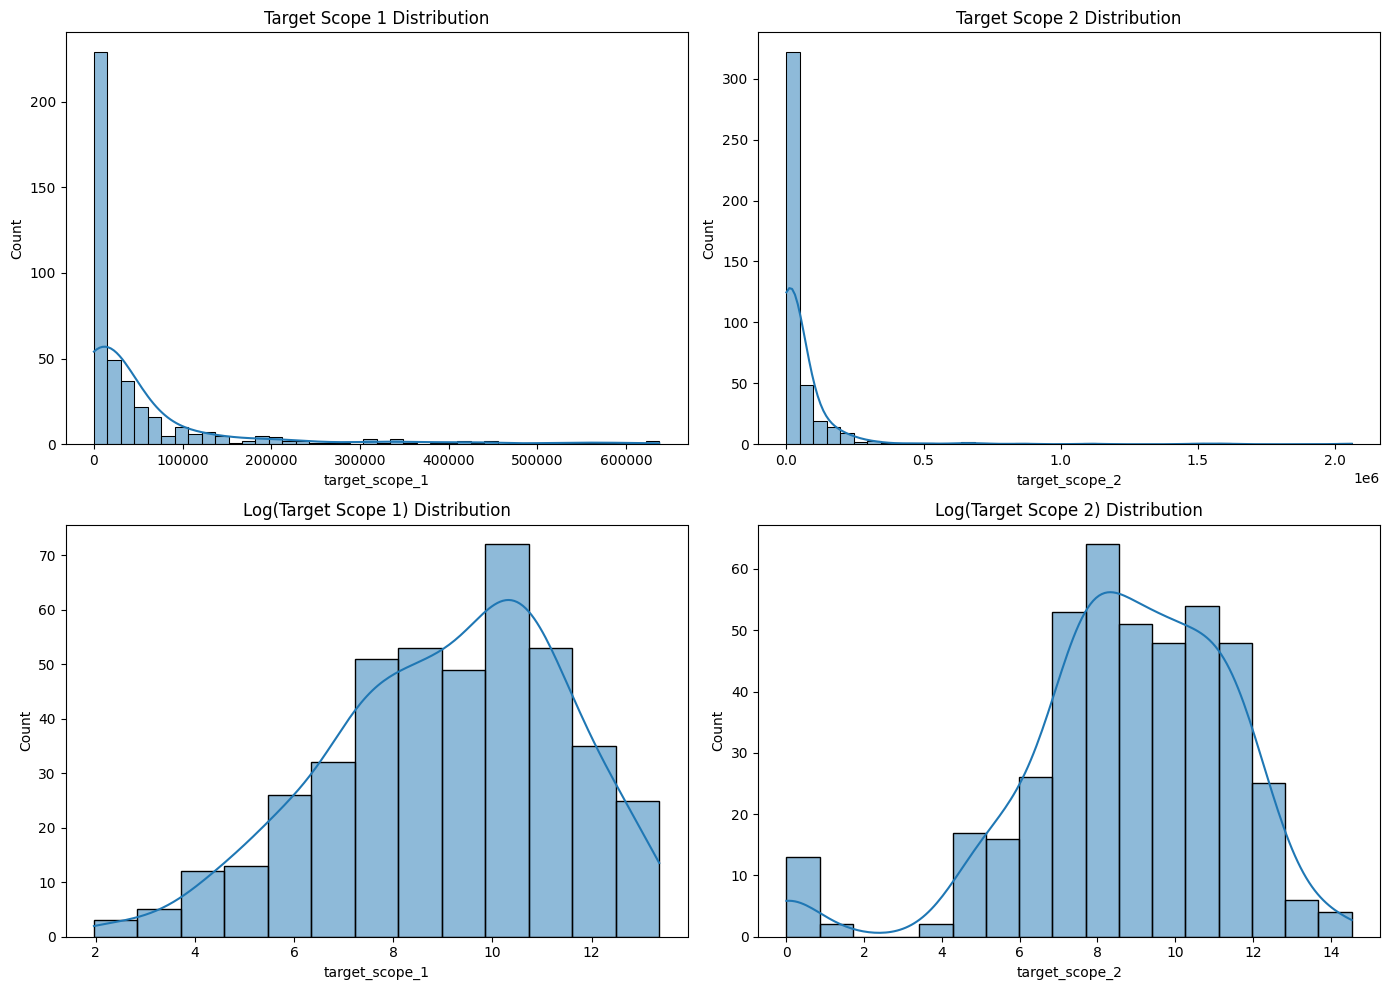

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv('data/train.csv')

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scope 1
sns.histplot(df['target_scope_1'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Target Scope 1 Distribution')

# Scope 2
sns.histplot(df['target_scope_2'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Target Scope 2 Distribution')

# Log Scope 1
sns.histplot(np.log1p(df['target_scope_1']), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Log(Target Scope 1) Distribution')

# Log Scope 2
sns.histplot(np.log1p(df['target_scope_2']), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Log(Target Scope 2) Distribution')

plt.tight_layout()
plt.show()


## 3.2 Why Median-Focused Prediction Is More Appropriate

For this task, we emphasize stable median predictions rather than precise modeling of extreme outliers. The main reasons are:

- **Extreme emission values** generally arise from specialized industrial assets such as power plants, refineries, or large-scale manufacturing facilities. These activities cannot be captured reliably without detailed operational disclosures, which are not available in this dataset.  
- ESG analysts and financial institutions primarily assess emissions at the **portfolio or sector level**, where stable central tendencies matter more than exact outlier accuracy.  
- Loss functions like **RMSE** can overemphasize a small number of extreme values as it's more sensitive to outliers, resulting in unstable or biased models.  
- Metrics such as **MAE**, **Log-MAE**, and **Log-RMSE** align more naturally with the distributional structure by focusing on the bulk of the data.

Therefore, a median-oriented modeling approach produces more robust and practically useful predictions.

## 3.3 Objective and Evaluation Metrics

Based on the distributional characteristics and practical use cases:

- **Primary objective:** Mean Absolute Error (MAE)  

- **Secondary metrics:** Log-MAE, Log-RMSE  

These design choices reduce sensitivity to heavy-tail noise, prioritize reliable central estimates, and align with the needs of typical users of emissions forecasts.


# 4. Feature Engineering Overview

The provided dataset includes **three** broad categories of features:

### 1. **Scale** of business

- revenue

- revenue distribution across NACE Level 2 sectors

These proxy for operational size and activity mix.

### 2. **Geography**

- region

- country

These relate to energy-grid intensity and regulatory environment.

### 3. **Behavioral** and **Sustainability** attributes

- environmental/social/governance score

- environmental activity adjustments

- SDG commitments


These reflect environmental maturity and may correlate with emissions performance.



# 5. Scale of Business

### 5.1 Hypothesis 1

> Business scale (revenue) is the strongest single driver of emissions.

#### Reasoning: 
Larger operations and higher production volumes lead directly to more emissions.

##### Empirical result
Spearman correlation between log revenue and total log emissions ≈ **0.42** which is a relatively strong univariate signal.


#### Conclusion: 
Revenue serves as the primary baseline feature.



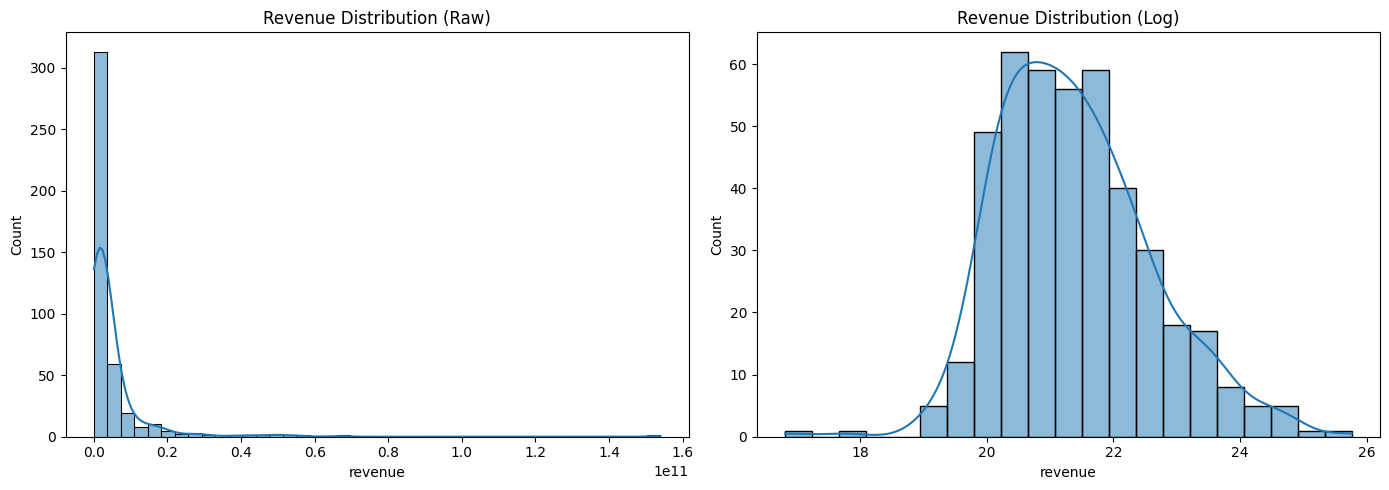

Correlation between Log(Revenue) and Log(Total Emissions): 0.4291


In [2]:
# Hypothesis 1: Revenue vs Emissions

# 1. Plot Revenue Distribution (Raw vs Log)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['revenue'], kde=True, ax=axes[0])
axes[0].set_title('Revenue Distribution (Raw)')

sns.histplot(np.log1p(df['revenue']), kde=True, ax=axes[1])
axes[1].set_title('Revenue Distribution (Log)')

plt.tight_layout()
plt.show()

# 2. Calculate Log Correlations
df['log_revenue'] = np.log1p(df['revenue'])
df['log_total_emissions'] = np.log1p(df['target_scope_1'] + df['target_scope_2'])

correlation = df['log_revenue'].corr(df['log_total_emissions'])
print(f"Correlation between Log(Revenue) and Log(Total Emissions): {correlation:.4f}")


### 5.2 Hypothesis 2

> Combined sectors in companies revenue contribution affects Scope 1 and Scope 2 differently.

#### Rationale based on **domain knowledge**

Scope 1 related sectors (manufacturing, mining, transportation)
→ Companies contributed more revenue in Scope 1 sector
→ stronger relationship with Scope 1 emission

Scope 2 related sectors (ICT, retail, services)
→ Companies contributed more revenue in Scope 2 sector
→ stronger relationship with Scope 2 emission

#### Procedure

1. Define two groups: **scope1-related sectors** and **scope2-related sectors**
    - Reasoning behind heauristic categorization consulting with domain expert (=llm) 
        - For example, Education sector is not belonged to either scope 1 or scope 2

2. Categorize each company's revenue distribution into two groups by joining train and revenue_distribution_by_sector tables.

3. Compute each company’s scope 1 revenue share and scope 2 revenue share individually.

4. Measure correlations & distribution.

#### Findings

- Sectors could be belonged to both or none of scope 1 & 2. 

- Scope 1 sector revenue is a subset of scope 2 revenue.

- High correlations between scope 1 revenue - scope 1 emission / scope 2 revenue - scope 2 emission.

- Company revenue contributions not belonged to neither scopes have relatively low emissions.

#### Conclusion: 
- Use sector-partitioned revenue as target-specific predictive features.

#### Features from the above insights
- log_total_revenue
- log_scope_1_revenue
- log_scope_2_revenue
- scope1_revenue_present (0/1)
- scope2_revenue_present (0/1)


,nace_level_1_code,nace_level_1_name,nace_level_2_name,affects_scope_1,affects_scope_2,company_count
0,A,"Agriculture, Forestry And Fishing","Crop and animal production, hunting and relate...",True,True,7
1,A,"Agriculture, Forestry And Fishing",Forestry and logging,True,True,1
2,B,Mining And Quarrying,Extraction of crude petroleum and natural gas,True,True,3
3,B,Mining And Quarrying,Mining of metal ores,True,True,1
4,B,Mining And Quarrying,Mining support service activities,True,True,1
...,...,...,...,...,...,...
74,R,Human Health And Social Work Activities,Gambling and betting activities,False,True,13
75,R,Human Health And Social Work Activities,Sports activities and amusement and recreation...,True,True,8
76,S,"Arts, Sports And Recreation",Other personal service activities,False,True,1
77,S,"Arts, Sports And Recreation","Repair and maintenance of computers, personal ...",False,False,1


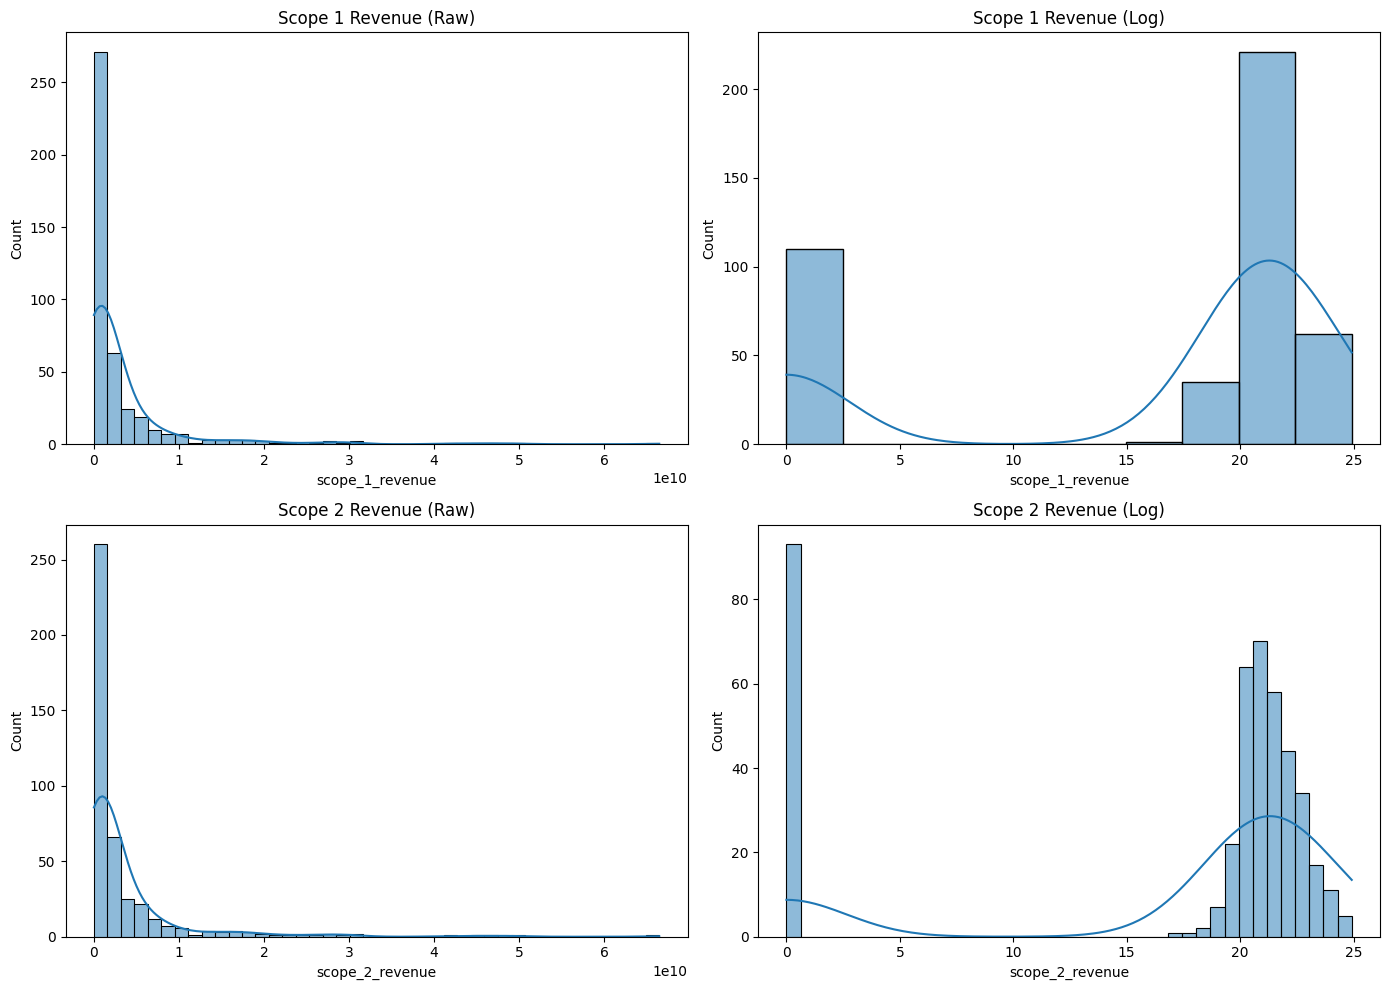

Correlation (Filtered > 0): Log(Scope 1 Revenue) vs Log(Scope 1 Emissions): 0.4437
Correlation (Filtered > 0): Log(Scope 2 Revenue) vs Log(Scope 2 Emissions): 0.3034
Companies with Scope 1 Revenue: 319
Companies with Scope 2 Revenue: 336
Companies with Both: 319
Companies with NO material sector revenue (Both False): 93


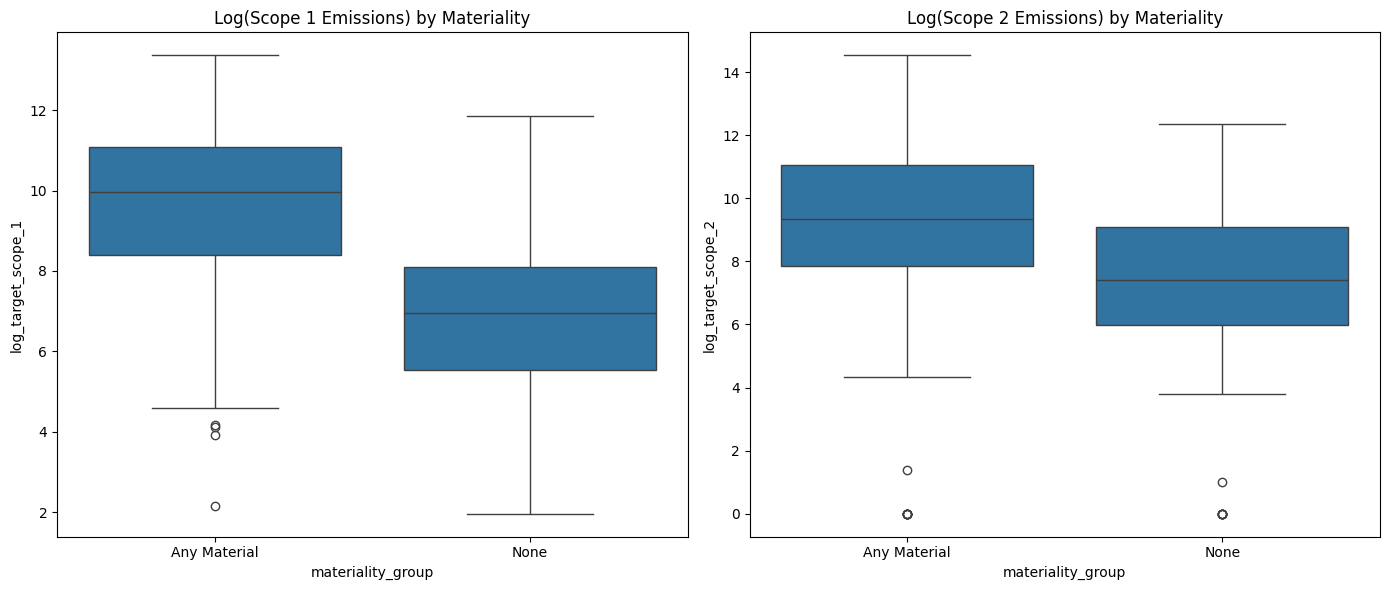

In [3]:
# Hypothesis 2: Sector Analysis

# Load sector data and classification
sector_df = pd.read_csv('data/revenue_distribution_by_sector.csv')
classification_df = pd.read_csv('data/sector_emission_scope_classification.csv')

# Merge classification
sector_df = pd.merge(sector_df, classification_df, on='nace_level_2_name', how='left')

# Fill missing classifications (if any) with False/True default (Scope 2 is universal)
sector_df['affects_scope_1'] = sector_df['affects_scope_1'].fillna(False)
sector_df['affects_scope_2'] = sector_df['affects_scope_2'].fillna(True)

# Create summary table
sector_summary = sector_df.groupby(['nace_level_1_code', 'nace_level_1_name', 'nace_level_2_name'])[['affects_scope_1', 'affects_scope_2']].first().reset_index()
sector_summary['company_count'] = sector_df.groupby(['nace_level_1_code', 'nace_level_1_name', 'nace_level_2_name']).size().values

# Display table
from IPython.display import display
display(sector_summary)

# Calculate Scope 1 / Scope 2 Revenue
merged_df = pd.merge(sector_df, df[['entity_id', 'revenue']], on='entity_id', how='inner')

# Calculate weighted revenue for each scope
# Note: A sector can contribute to BOTH Scope 1 and Scope 2
merged_df['scope_1_revenue_part'] = merged_df['revenue'] * merged_df['revenue_pct'] * merged_df['affects_scope_1'].astype(int)
merged_df['scope_2_revenue_part'] = merged_df['revenue'] * merged_df['revenue_pct'] * merged_df['affects_scope_2'].astype(int)

# Aggregate by entity
entity_revenue_split = merged_df.groupby('entity_id')[['scope_1_revenue_part', 'scope_2_revenue_part']].sum().reset_index()
entity_revenue_split.rename(columns={'scope_1_revenue_part': 'scope_1_revenue', 'scope_2_revenue_part': 'scope_2_revenue'}, inplace=True)

final_df = pd.merge(df, entity_revenue_split, on='entity_id', how='left').fillna(0)

# 1. Plot Scope 1 / Scope 2 Revenue Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(final_df['scope_1_revenue'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Scope 1 Revenue (Raw)')

sns.histplot(np.log1p(final_df['scope_1_revenue']), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Scope 1 Revenue (Log)')

sns.histplot(final_df['scope_2_revenue'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Scope 2 Revenue (Raw)')

sns.histplot(np.log1p(final_df['scope_2_revenue']), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Scope 2 Revenue (Log)')

plt.tight_layout()
plt.show()

# 2. Calculate Log Correlations (Filtered for non-zero revenue)
final_df['log_scope_1_revenue'] = np.log1p(final_df['scope_1_revenue'])
final_df['log_scope_2_revenue'] = np.log1p(final_df['scope_2_revenue'])
final_df['log_target_scope_1'] = np.log1p(final_df['target_scope_1'])
final_df['log_target_scope_2'] = np.log1p(final_df['target_scope_2'])

# Filter for non-zero scope 1 revenue
df_s1 = final_df[final_df['scope_1_revenue'] > 0]
corr_s1 = df_s1['log_scope_1_revenue'].corr(df_s1['log_target_scope_1'])

# Filter for non-zero scope 2 revenue
df_s2 = final_df[final_df['scope_2_revenue'] > 0]
corr_s2 = df_s2['log_scope_2_revenue'].corr(df_s2['log_target_scope_2'])

print(f"Correlation (Filtered > 0): Log(Scope 1 Revenue) vs Log(Scope 1 Emissions): {corr_s1:.4f}")
print(f"Correlation (Filtered > 0): Log(Scope 2 Revenue) vs Log(Scope 2 Emissions): {corr_s2:.4f}")

# 3. Report Company Counts
has_s1 = (final_df['scope_1_revenue'] > 0).sum()
has_s2 = (final_df['scope_2_revenue'] > 0).sum()
has_both = ((final_df['scope_1_revenue'] > 0) & (final_df['scope_2_revenue'] > 0)).sum()
has_neither = ((final_df['scope_1_revenue'] == 0) & (final_df['scope_2_revenue'] == 0)).sum()

print(f"Companies with Scope 1 Revenue: {has_s1}")
print(f"Companies with Scope 2 Revenue: {has_s2}")
print(f"Companies with Both: {has_both}")
print(f"Companies with NO material sector revenue (Both False): {has_neither}")

# 4. Box Plots for Materiality Groups
final_df['materiality_group'] = 'Any Material'
final_df.loc[(final_df['scope_1_revenue'] == 0) & (final_df['scope_2_revenue'] == 0), 'materiality_group'] = 'None'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='materiality_group', y='log_target_scope_1', data=final_df, ax=axes[0])
axes[0].set_title('Log(Scope 1 Emissions) by Materiality')

sns.boxplot(x='materiality_group', y='log_target_scope_2', data=final_df, ax=axes[1])
axes[1].set_title('Log(Scope 2 Emissions) by Materiality')

plt.tight_layout()
plt.show()


# TODO: scope 2 = usage * country-wise-factors
- scope 1 factor: 국가별 차이 5% ~ 15% 수준
- scope 2 factor: 최대 50배, 전력 믹스 구성

가설: 사업 규모 (revenue) 가 같으면, 에너지 사용량이 같은데,
국가가 다르면 factor가 다르기에 target scope 1/2 value가 차이가 날 것이다

scope 1에 대해서 비슷한 규모의 회사들끼리 비교했을때 국가별 차이가 큰지 보기. 기대: 차이 작다
scope 2에서 마찬가지. 기대: 차이 크다
신뢰수준 볼 수 있을 정도려나
기대 결과: scope 2 예측에는 국가 피쳐 의미 있다, 하지만 test set 보면 특정 region만 나와서 의미 별로 없을 것.
fairness/bias 문제 조심.

# 6. Geography Analysis
Region

In the train set, WEU and NAM dominate; other regions have only a handful of records.

In the test set, only WEU and NAM appear.

Minority regions are grouped as “Others” to reduce noise and instability.

Note: potential fairness and bias issues should be revisited in future work.

Country

Some countries have very few data points.

Countries with more samples often show very high variance.

Country-level features were therefore removed due to lack of consistent signal.



In [4]:
import numpy as np
import pandas as pd
from scipy import stats

def analyze_country_factors(df, scope_col, revenue_col, country_col='country_code', 
                            n_quantiles=10, use_log_target=False):
    """
    use_log_target=False → 기존 raw target 분석
    use_log_target=True  → log1p(target) 기반 안정화된 factor 분석
    """
    
    df = df.copy()
    
    # Create log target column if needed
    if use_log_target:
        scope_col_used = f"log_{scope_col}"
        df[scope_col_used] = np.log1p(df[scope_col])
        print(f"\n=== Log-Transformed Analysis for {scope_col} vs {revenue_col} ===")
    else:
        scope_col_used = scope_col
        print(f"\n=== Analysis for {scope_col} vs {revenue_col} ===")
    
    # Step A: Filter and Quantiles
    df_valid = df[df[revenue_col] > 0].copy()
    df_valid['log_revenue'] = np.log1p(df_valid[revenue_col])
    
    # Quantile binning
    try:
        df_valid['quantile'] = pd.qcut(df_valid['log_revenue'], n_quantiles, labels=False)
    except ValueError:
        print("Warning: Not enough unique revenue values for quantiles. Using rank-based binning.")
        df_valid['quantile'] = pd.qcut(df_valid['log_revenue'].rank(method='first'), n_quantiles, labels=False)
    
    # Step B-D: Per group analysis
    for q in range(n_quantiles):
        group_df = df_valid[df_valid['quantile'] == q]
        if group_df.empty:
            continue
        
        country_counts = group_df[country_col].value_counts()
        if country_counts.empty:
            continue
        
        baseline_country = country_counts.idxmax()
        baseline_data = group_df[group_df[country_col] == baseline_country][scope_col_used]
        
        # Stats
        b_min = baseline_data.min()
        b_max = baseline_data.max()
        b_mean = baseline_data.mean()
        b_std = baseline_data.std()
        b_median = baseline_data.median()
        
        print(f"\n[Group {q} (Quantile {q+1}/{n_quantiles})]")
        print(f"- Baseline country: {baseline_country} (n={len(baseline_data)})")
        print(f"- Baseline stats: min={b_min:.4f}, max={b_max:.4f}, mean={b_mean:.4f}, std={b_std:.4f}, median={b_median:.4f}")
        
        results = []
        
        for country in country_counts.index:
            if country == baseline_country:
                continue
            
            c_data = group_df[group_df[country_col] == country][scope_col_used]
            if len(c_data) < 2:
                continue
            
            c_mean = c_data.mean()
            c_std = c_data.std()
            
            # Ratio changes if using log or raw
            if use_log_target:
                # In log space: exp(mean difference) gives multiplicative factor
                mean_ratio = np.exp(c_mean - b_mean)
            else:
                mean_ratio = c_mean / b_mean if b_mean != 0 else np.nan
            
            # Welch test
            t_stat, p_val = stats.ttest_ind(c_data, baseline_data, equal_var=False)
            is_sig = "Yes" if p_val < 0.05 else "No"
            
            results.append({
                'Country': country,
                'n': len(c_data),
                'Mean': c_mean,
                'Std': c_std,
                'Ratio': mean_ratio,
                'p-value': p_val,
                'Sig?': is_sig
            })
        
        if results:
            print(pd.DataFrame(results).to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
        else:
            print("No other countries with sufficient data for comparison.")


# Run Analysis for Scope 1
# Note: Using 'scope_1_revenue' calculated in previous step
analyze_country_factors(final_df, 'target_scope_1', 'scope_1_revenue')

# Run Analysis for Scope 2
# Note: Using 'scope_2_revenue' calculated in previous step
analyze_country_factors(final_df, 'target_scope_2', 'scope_2_revenue')

# Run Analysis for Log Scope 1
analyze_country_factors(final_df, 'target_scope_1', 'scope_1_revenue', use_log_target=True)

# Run Analysis for Log Scope 2
analyze_country_factors(final_df, 'target_scope_2', 'scope_2_revenue', use_log_target=True)




=== Analysis for target_scope_1 vs scope_1_revenue ===

[Group 0 (Quantile 1/10)]
- Baseline country: US (n=8)
- Baseline stats: min=183.0000, max=146713.0000, mean=19508.0875, std=51442.1905, median=381.0000
Country  n      Mean        Std  Ratio  p-value Sig?
     GB  5 1865.3400  2461.4722 0.0956   0.3649   No
     NL  4 7115.2500  9369.0699 0.3647   0.5282   No
     IT  4 6889.3600  5566.1649 0.3532   0.5139   No
     ES  3 7285.8067 11946.2002 0.3735   0.5462   No
     DE  2 4009.5000  3329.7658 0.2055   0.4252   No
     LU  2 3016.0000   333.7544 0.1546   0.3947   No

[Group 1 (Quantile 2/10)]
- Baseline country: FR (n=6)
- Baseline stats: min=1290.6800, max=138437.0000, mean=28640.2200, std=54059.6302, median=7115.5000
Country  n       Mean         Std  Ratio  p-value Sig?
     US  6 65752.8333  52035.7681 2.2958   0.2536   No
     LU  3  2707.8467   2599.5724 0.0945   0.2934   No
     GB  3 10158.3600  11075.7505 0.3547   0.4530   No
     IT  3 63735.3333 107530.1996 2.2254   

국가 피쳐는
- 단독 feature로는 강한 signal이 없다
- scope 1, 2 정의 생각하면 있어야 마땅하다.
- 데이터가 적어서 variance가 너무 커서 지금 단계에서는 detect가 안 되었을 뿐이다
- 일부는 sig 하다고 나오긴 했다 특히 n이 큰 경우들에 대해서.
- 실제 랜덤포레스트/LightGBM 모델에 넣으면 성능 개선에 기여할 가능성 있음 (왜냐하면 도메인 지식 + 약간의 sig 한 결과)

Region은
- weu, nam 제외하면 나머지 5개 region을 가진 회사가 10개도 안됨
- country가 더 세밀한 정보를 제공함

=> 결론: 국가 피쳐 쓴다 (categorical). region feature 안쓴다

# 7. Behavioral Features

Not yet fully explored.

Potential signals:

Negative environmental adjustments indicate beneficial activities.

SDG commitments (especially SDG 13 “Climate Action”).

ESG scores may reflect process maturity but can be noisy.

Further EDA is required to validate their predictive value.



# 7.1 overall_score & e/s/g score
- overall = 0.45 * e + 0.3 * s + 0.25 * g => exclude overall score as a feature due to multicolinearity
- 1 to 5 scale. closer to 1 the better
- data/environmental_activities.csv: e score adjustment. simple addition? (additive adjustment)

In [5]:
import numpy as np
import pandas as pd

# Load environmental activities
env_activities = pd.read_csv('data/environmental_activities.csv')

# Aggregate adjustments by entity_id
env_adj_agg = env_activities.groupby('entity_id')['env_score_adjustment'].sum().reset_index()

# Merge with final_df
# We use left merge to keep all companies in final_df, filling missing adjustments with 0
analysis_df = final_df.merge(env_adj_agg, on='entity_id', how='left')
analysis_df['env_score_adjustment'] = analysis_df['env_score_adjustment'].fillna(0)

# Calculate adjusted scores
analysis_df['env_adjusted'] = analysis_df['environmental_score'] + analysis_df['env_score_adjustment']
analysis_df['overall_adjusted'] = (0.45 * analysis_df['env_adjusted'] + 
                                   0.3 * analysis_df['social_score'] + 
                                   0.25 * analysis_df['governance_score'])

# Create log targets
analysis_df['log_target_scope_1'] = np.log1p(analysis_df['target_scope_1'])
analysis_df['log_target_scope_2'] = np.log1p(analysis_df['target_scope_2'])

# === Global Correlations (No Quantiles) ===
global_targets = [
    ('Scope 1 Target', 'target_scope_1'),
    ('Log Scope 1 Target', 'log_target_scope_1'),
    ('Scope 2 Target', 'target_scope_2'),
    ('Log Scope 2 Target', 'log_target_scope_2')
]

score_cols_map = {
    'overall_score': 'overall',
    'overall_adjusted': 'overall_adjusted',
    'environmental_score': 'env',
    'env_adjusted': 'env_adjusted',
    'social_score': 'social',
    'governance_score': 'governance'
}

global_results = []
for label, t_col in global_targets:
    row = {'target': label}
    for s_col, s_label in score_cols_map.items():
        # Calculate correlation on the full dataset (ignoring NaNs)
        row[s_label] = analysis_df[t_col].corr(analysis_df[s_col])
    global_results.append(row)

global_corr_df = pd.DataFrame(global_results)
# Ensure column order
global_cols = ['target', 'overall', 'overall_adjusted', 'env', 'env_adjusted', 'social', 'governance']
global_corr_df = global_corr_df[global_cols]

print("=== Global Correlations (All Data) ===")
print(global_corr_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
print("\n")

# === Quantile Analysis ===
def calculate_quantile_correlations(df, revenue_col, target_col, title):
    score_cols = ['overall_score', 'overall_adjusted', 'environmental_score', 'env_adjusted', 'social_score', 'governance_score']
    
    # Filter for valid revenue
    valid_df = df[df[revenue_col] > 0].copy()
    
    # Create quantiles
    n_quantiles = 10
    try:
        valid_df['quantile'] = pd.qcut(valid_df[revenue_col], n_quantiles, labels=False)
    except ValueError:
        # Fallback if not enough unique values
        valid_df['quantile'] = pd.qcut(valid_df[revenue_col].rank(method='first'), n_quantiles, labels=False)
    
    # Calculate correlations per group
    results = []
    for q in range(n_quantiles):
        group_data = valid_df[valid_df['quantile'] == q]
        if len(group_data) < 2:
            continue
        
        row = {'quantile group': q}
        for col in score_cols:
            corr = group_data[col].corr(group_data[target_col])
            row[col] = corr
        results.append(row)
    
    # Create result dataframe
    corr_table = pd.DataFrame(results)
    
    # Rename columns for display
    corr_table = corr_table.rename(columns={
        'overall_score': 'overall',
        'environmental_score': 'env',
        'social_score': 'social',
        'governance_score': 'governance'
    })
    
    # Reorder columns
    display_cols = ['quantile group', 'overall', 'overall_adjusted', 'env', 'env_adjusted', 'social', 'governance']
    corr_table = corr_table[display_cols]
    
    print(f"=== {title} ===")
    print(corr_table.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
    print("\n")

# 1. Scope 1 Revenue vs Target Scope 1
calculate_quantile_correlations(analysis_df, 'scope_1_revenue', 'target_scope_1', 
                              'Correlation: Scope 1 Revenue Quantile vs Target Scope 1')

# 2. Scope 1 Revenue vs Log Target Scope 1
calculate_quantile_correlations(analysis_df, 'scope_1_revenue', 'log_target_scope_1', 
                              'Correlation: Scope 1 Revenue Quantile vs Log Target Scope 1')

# 3. Scope 2 Revenue vs Target Scope 2
calculate_quantile_correlations(analysis_df, 'scope_2_revenue', 'target_scope_2', 
                              'Correlation: Scope 2 Revenue Quantile vs Target Scope 2')

# 4. Scope 2 Revenue vs Log Target Scope 2
calculate_quantile_correlations(analysis_df, 'scope_2_revenue', 'log_target_scope_2', 
                              'Correlation: Scope 2 Revenue Quantile vs Log Target Scope 2')


=== Global Correlations (All Data) ===
            target  overall  overall_adjusted    env  env_adjusted  social  governance
    Scope 1 Target   0.0718            0.0577 0.1197        0.0963  0.0465     -0.1130
Log Scope 1 Target   0.0876            0.0581 0.1546        0.1097  0.0628     -0.1639
    Scope 2 Target  -0.0069           -0.0462 0.0490       -0.0054  0.0342     -0.1671
Log Scope 2 Target   0.1025            0.0741 0.1477        0.1060  0.1045     -0.1599


=== Correlation: Scope 1 Revenue Quantile vs Target Scope 1 ===
 quantile group  overall  overall_adjusted     env  env_adjusted  social  governance
              0   0.2695            0.2829  0.2287        0.2338  0.1730      0.2061
              1  -0.0653            0.0000 -0.0919        0.0122  0.0296     -0.1050
              2  -0.2486           -0.2506 -0.2533       -0.2488  0.0969     -0.1540
              3   0.2019            0.2148  0.2978        0.2803  0.1471     -0.2299
              4   0.1403           

- 산업 규모를 무시하고 보면 correlation 작아보임
- 산업 규모(revenue)를 고려하면 그룹마다 correlation 꽤 크게 보이는 경우 있음
- 음수/양수 들쭉날쭉 해서 비선형적인 관계겠지만 사용하기에 좋은 피쳐라는 뜻. 어차피 산업 규모(revenue)도 피쳐로 들어가기 때문.
- 비선형적 모델 ex) XGBoost 를 쓸때 도움될 것
- 그리고 overall vs overall adjusted, env vs env adjusted 비교해봤을때, adjusted score가 consistent하게 더 correlation이 크기에 더 좋은 피쳐다
- overall은 e/s/g score의 weighted sum이라 multicolinearity를 유발하지만 그럼에도 correlation이 전반적으로 크고 tree model에선 큰 문제가 되지 않을 것이기에 쓰는게 좋다

결론: esg score feature를 사용하되, env는 adjusted로 써야 한다, overall score도 쓸거다

# 7.2 sdg


In [6]:
import scipy.stats as stats

# Load SDG data
sdg_df = pd.read_csv('data/sustainable_development_goals.csv')
unique_sdgs = sdg_df[['sdg_id', 'sdg_name']].drop_duplicates().sort_values('sdg_id')

# Targets to analyze
targets = [
    ('target_scope_1', 'target scope 1'),
    ('log_target_scope_1', 'target scope 1 log'),
    ('target_scope_2', 'target scope 2'),
    ('log_target_scope_2', 'target scope 2 log')
]

significant_cases = []

for _, row in unique_sdgs.iterrows():
    sdg_id = row['sdg_id']
    sdg_name = row['sdg_name']
    
    print(f"[======={sdg_name} ({sdg_id})=======]")
    
    # Identify entities with this SDG
    entities_with_sdg = sdg_df[sdg_df['sdg_id'] == sdg_id]['entity_id'].unique()
    
    has_sdg = analysis_df['entity_id'].isin(entities_with_sdg)
    group_exist = analysis_df[has_sdg]
    group_non_exist = analysis_df[~has_sdg]
    
    # Global comparison table
    print("|target | N(exist) | N(non-exist) | existence mean | non existence mean | p-value | is significant|")
    for col, label in targets:
        a = group_exist[col].dropna()
        b = group_non_exist[col].dropna()
        
        n_exist = len(a)
        n_non_exist = len(b)
        
        if n_exist > 1 and n_non_exist > 1:
            stat, pval = stats.ttest_ind(a, b, equal_var=False)
            mean_exist = a.mean()
            mean_non_exist = b.mean()
            is_sig = pval < 0.05
        else:
            mean_exist = np.nan
            mean_non_exist = np.nan
            pval = np.nan
            is_sig = False
            
        print(f"|{label}| {n_exist} | {n_non_exist} | {mean_exist:.4f} | {mean_non_exist:.4f} | {pval:.4f} | {is_sig}|")
        
        if is_sig:
            significant_cases.append({
                'type': 'Global',
                'sdg': f"{sdg_name} ({sdg_id})",
                'target': label,
                'quantile': 'All',
                'p_value': pval,
                'mean_diff': mean_exist - mean_non_exist
            })
            
    print("\n")

    # Quantile Analysis Helper
    def run_quantile_analysis(revenue_col, target_col, target_label, quantile_label):
        print(f"[{quantile_label}, {target_label} mean comparison]")
        print("|quantile group| N(exist) | N(non-exist) | existence mean | non existence mean | p-value | is significant|")
        
        temp_df = analysis_df[analysis_df[revenue_col] > 0].copy()
        
        try:
            temp_df['quantile'] = pd.qcut(temp_df[revenue_col], 10, labels=False)
        except ValueError:
             temp_df['quantile'] = pd.qcut(temp_df[revenue_col].rank(method='first'), 10, labels=False)
             
        for q in range(10):
            q_data = temp_df[temp_df['quantile'] == q]
            
            has_sdg_q = q_data['entity_id'].isin(entities_with_sdg)
            g_exist = q_data[has_sdg_q][target_col].dropna()
            g_non_exist = q_data[~has_sdg_q][target_col].dropna()
            
            n_exist = len(g_exist)
            n_non_exist = len(g_non_exist)
            
            if n_exist > 1 and n_non_exist > 1:
                stat, pval = stats.ttest_ind(g_exist, g_non_exist, equal_var=False)
                m_exist = g_exist.mean()
                m_non_exist = g_non_exist.mean()
                is_sig = pval < 0.05
            else:
                m_exist = np.nan
                m_non_exist = np.nan
                pval = np.nan
                is_sig = False
            
            print(f"|{q}| {n_exist} | {n_non_exist} | {m_exist:.4f} | {m_non_exist:.4f} | {pval:.4f} | {is_sig}|")
            
            if is_sig:
                significant_cases.append({
                    'type': 'Quantile',
                    'sdg': f"{sdg_name} ({sdg_id})",
                    'target': target_label,
                    'quantile': f"{quantile_label} (Group {q})",
                    'p_value': pval,
                    'mean_diff': m_exist - m_non_exist
                })
        print("\n")

    run_quantile_analysis('scope_1_revenue', 'target_scope_1', 'target scope 1', 'scope 1 revenue quantile')
    run_quantile_analysis('scope_1_revenue', 'log_target_scope_1', 'target scope 1 log', 'scope 1 revenue quantile')
    run_quantile_analysis('scope_2_revenue', 'target_scope_2', 'target scope 2', 'scope 2 revenue quantile')
    run_quantile_analysis('scope_2_revenue', 'log_target_scope_2', 'target scope 2 log', 'scope 2 revenue quantile')
    
    print("-" * 50 + "\n")

print("=== Summary of Significant Cases ===")
if significant_cases:
    sig_df = pd.DataFrame(significant_cases)
    # Sort by p-value for better readability
    sig_df = sig_df.sort_values('p_value')
    print(sig_df.to_string(index=False))
else:
    print("No significant cases found.")


[=======Zero Hunger (2)=======]
|target | N(exist) | N(non-exist) | existence mean | non existence mean | p-value | is significant|
|target scope 1| 5 | 424 | 172391.8000 | 54370.1028 | 0.1659 | False|
|target scope 1 log| 5 | 424 | 11.3615 | 9.0490 | 0.0293 | True|
|target scope 2| 5 | 424 | 117916.6000 | 56721.5214 | 0.3907 | False|
|target scope 2 log| 5 | 424 | 10.4604 | 8.7323 | 0.1464 | False|


[scope 1 revenue quantile, target scope 1 mean comparison]
|quantile group| N(exist) | N(non-exist) | existence mean | non existence mean | p-value | is significant|
|0| 0 | 32 | nan | nan | nan | False|
|1| 0 | 32 | nan | nan | nan | False|
|2| 1 | 31 | nan | nan | nan | False|
|3| 0 | 32 | nan | nan | nan | False|
|4| 0 | 32 | nan | nan | nan | False|
|5| 1 | 30 | nan | nan | nan | False|
|6| 0 | 32 | nan | nan | nan | False|
|7| 1 | 31 | nan | nan | nan | False|
|8| 0 | 32 | nan | nan | nan | False|
|9| 2 | 30 | 326861.5000 | 139898.7333 | 0.0004 | True|


[scope 1 revenue quantile, ta

- SDG는 예측 신호가 아니다
- Global에서 유의미해도 규모로 통제하면 사라짐. 즉, “기업 규모가 매우 작은 기업들만 SDG를 가진 경향” 같은 confounding effect일 가능성.
- SDG는 자기보고(self-reported)이며 실제 운영과 먼 경우가 많음
- 표본이 너무 적음
- 따라서 피쳐로 사용하지 않는다

# 9. Experimentation

Baseline (provided by organizers)

Full feature set

One-hot encoding

Variance-threshold filtering

Standard scaling

Linear regression model

Our Model 1 (planned)

Separate models for Scope 1 and Scope 2

Log-transformed targets

Feature engineering using direct vs indirect revenue segmentation

Tree-based models (e.g., LightGBM/XGBoost) to capture nonlinear interactions

Cross-validation grouped by revenue decile or region to prevent leakage

Additional ensemble or stacking approaches may be added later.

In [7]:
import pandas as pd
import json
import sys
import os
import src.models as models_module
import src.preprocessor as preprocessor_module
from src.trainer import Trainer
from src.experiment_manager import ExperimentManager

# Helper functions from train.py
def load_data():
    print("Loading data...")
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    return train, test

def get_class(module, class_name):
    if hasattr(module, class_name):
        return getattr(module, class_name)
    else:
        raise ValueError(f"Class {class_name} not found in module {module.__name__}")

# Main execution
print("Starting Baseline Experiment...")

# Load configuration
config_path = "experiments/configs/baseline_config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

print(f"Loaded config: {config['name']}")

# Load data
train_df, test_df = load_data()

# Initialize Preprocessor
preprocessor_config = config.get("preprocessor", {})
preprocessor_class_name = preprocessor_config.get("name", "BaselinePreprocessor")
preprocessor_params = preprocessor_config.get("params", {})

print(f"Initializing preprocessor: {preprocessor_class_name}")
PreprocessorClass = get_class(preprocessor_module, preprocessor_class_name)
preprocessor = PreprocessorClass(**preprocessor_params)

print("Preprocessing data...")
X = preprocessor.fit_transform(train_df)

# Target extraction
y_scope1 = train_df['target_scope_1']
y_scope2 = train_df['target_scope_2']

# Initialize Model
model_config = config.get("model", {})
model_class_name = model_config.get("name", "LinearRegressionModel")
model_params = model_config.get("params", {})

print(f"Initializing model: {model_class_name}")
ModelClass = get_class(models_module, model_class_name)

# Initialize Trainer
trainer_params = config.get("trainer", {})
trainer = Trainer(
    model_class=ModelClass,
    model_params=model_params,
    **trainer_params
)

# Train and Evaluate
metrics = {}

print("\n--- Training Target Scope 1 (CV) ---")
metrics["scope_1"] = trainer.train(X, y_scope1)

print("\n--- Training Target Scope 2 (CV) ---")
metrics["scope_2"] = trainer.train(X, y_scope2)

print("\n--- Experiment Results ---")
print(json.dumps(metrics, indent=4))

# Print specific metrics
print("\n--- Linear Regression + Baseline Features ---")
for scope in ["scope_1", "scope_2"]:
    print(f"{scope} Mean MAE: {metrics[scope]['mean_mae']:.4f}")
    print(f"{scope} Mean Log MAE: {metrics[scope]['mean_log_mae']:.4f}")
    print(f"{scope} Mean Log RMSE: {metrics[scope]['mean_log_rmse']:.4f}")


Starting Baseline Experiment...
Loaded config: baseline_run
Loading data...
Initializing preprocessor: CodeathonBaselinePreprocessor
Preprocessing data...
Selected 13 features with variance > 0.05
Initializing model: LinearRegressionModel

--- Training Target Scope 1 (CV) ---
Starting training with 5 folds... (Log Target: False)
Fold 1/5 - RMSE: 141019.2523, MAE: 74672.4646 | Log RMSE: 3.5006, Log MAE: 2.7026
Fold 2/5 - RMSE: 100115.6783, MAE: 61353.7206 | Log RMSE: 3.3454, Log MAE: 2.4642
Fold 3/5 - RMSE: 109294.4353, MAE: 67979.7016 | Log RMSE: 3.1987, Log MAE: 2.3412
Fold 4/5 - RMSE: 92291.3971, MAE: 58091.2565 | Log RMSE: 3.9357, Log MAE: 2.8964
Fold 5/5 - RMSE: 91616.9029, MAE: 59948.4222 | Log RMSE: 3.5561, Log MAE: 2.5194

Training Completed.
Mean RMSE: 106867.5332
Mean MAE: 64409.1131
Mean Log RMSE: 3.5073
Mean Log MAE: 2.5848

Top 5 Worst Predictions (Across all folds):
       actual      predicted      abs_error
420  637605.0   79810.295807  557794.704193
331    9998.0  55303

In [8]:
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from src.models import BaseModel

print("\n=== Starting Median Regression Experiment ===")

class MedianRegressionModel(BaseModel):
    def __init__(self):
        self.model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', QuantileRegressor(quantile=0.5, solver='highs'))
        ])

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Initialize Trainer for Median Regression
median_trainer = Trainer(
    model_class=MedianRegressionModel,
    model_params={},
    n_splits=5,
    random_state=42
)

median_metrics = {}

print("\n--- Training Target Scope 1 (Median Regression) ---")
median_metrics["scope_1"] = median_trainer.train(X, y_scope1)

print("\n--- Training Target Scope 2 (Median Regression) ---")
median_metrics["scope_2"] = median_trainer.train(X, y_scope2)

print("\n--- Median Regression + Baseline Features ---")
for scope in ["scope_1", "scope_2"]:
    print(f"{scope} Mean MAE: {median_metrics[scope]['mean_mae']:.4f}")
    print(f"{scope} Mean Log MAE: {median_metrics[scope]['mean_log_mae']:.4f}")
    print(f"{scope} Mean Log RMSE: {median_metrics[scope]['mean_log_rmse']:.4f}")



=== Starting Median Regression Experiment ===

--- Training Target Scope 1 (Median Regression) ---
Starting training with 5 folds... (Log Target: False)
Fold 1/5 - RMSE: 149903.1853, MAE: 62211.4391 | Log RMSE: 2.6768, Log MAE: 2.1774
Fold 2/5 - RMSE: 122971.2082, MAE: 61430.4745 | Log RMSE: 2.3743, Log MAE: 2.0268
Fold 3/5 - RMSE: 112601.9893, MAE: 47994.9160 | Log RMSE: 1.9473, Log MAE: 1.6023
Fold 4/5 - RMSE: 89245.7073, MAE: 38781.8234 | Log RMSE: 2.3311, Log MAE: 1.8595
Fold 5/5 - RMSE: 111741.0206, MAE: 54511.3994 | Log RMSE: 2.5253, Log MAE: 2.0178

Training Completed.
Mean RMSE: 117292.6221
Mean MAE: 52986.0105
Mean Log RMSE: 2.3710
Mean Log MAE: 1.9368

Top 5 Worst Predictions (Across all folds):
       actual  predicted  abs_error
420  637605.0    12879.0   624726.0
424  631252.0    12879.0   618373.0
421  598000.0    12879.0   585121.0
396  577624.0     9866.0   567758.0
150  568478.0     9866.0   558612.0

--- Training Target Scope 2 (Median Regression) ---
Starting traini

In [9]:
from src.preprocessor import MedianRegressionPreprocessor
from src.models import MedianRegressionModel
from src.trainer import Trainer
import pandas as pd

print("\n=== Starting Median Regression Experiment (New Features) ===")

# Initialize Preprocessor
print("Initializing preprocessor: MedianRegressionPreprocessor")
median_preprocessor = MedianRegressionPreprocessor()

print("Preprocessing data...")
# Assuming train_df is available from previous cells
if 'train_df' not in locals():
    print("Loading data...")
    train_df = pd.read_csv("data/train.csv")

X_median = median_preprocessor.fit_transform(train_df)
y_scope1 = train_df['target_scope_1']
y_scope2 = train_df['target_scope_2']

# Initialize Trainer
median_trainer = Trainer(
    model_class=MedianRegressionModel,
    model_params={},
    n_splits=5,
    random_state=42
)

median_metrics = {}

print("\n--- Training Target Scope 1 (Median Regression) ---")
median_metrics["scope_1"] = median_trainer.train(X_median, y_scope1)

print("\n--- Training Target Scope 2 (Median Regression) ---")
median_metrics["scope_2"] = median_trainer.train(X_median, y_scope2)

print("\n--- Median Regression + New Features Results ---")
for scope in ["scope_1", "scope_2"]:
    print(f"{scope} Mean MAE: {median_metrics[scope]['mean_mae']:.4f}")
    print(f"{scope} Mean Log MAE: {median_metrics[scope]['mean_log_mae']:.4f}")
    print(f"{scope} Mean Log RMSE: {median_metrics[scope]['mean_log_rmse']:.4f}")


=== Starting Median Regression Experiment (New Features) ===
Initializing preprocessor: MedianRegressionPreprocessor
Preprocessing data...


KeyError: 'nace_level_1_code'

# TODO: hyperparam optimization

# 10. Conclusion